In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tikzplotlib

In [13]:
## reset defaults
plt.rcdefaults()

## Set up LaTeX fonts
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    })

In [14]:
class Receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y

class Receiver2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(128, 128)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(128, M)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)

class Encoder(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M, bias=False)
        nn.init.constant_(self.lin1.weight, 1 / M)
        self.out = nn.Softmax(dim=0)

    def forward(self, y):
        return self.out(self.lin1(y))

class Mapper(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 1)

    def forward(self, y):
        y = self.lin1(y)
        return y

In [15]:
def sampler(prob, n):
    samples = torch.empty(0)
    for idx, p in enumerate(prob):
        occurrences = torch.round(n * p).type(torch.LongTensor)
        samples = torch.cat((samples, torch.ones(occurrences, dtype=torch.int64) * torch.tensor(idx)))
    indexes = torch.randperm(samples.shape[0])
    return samples[indexes]

def gradient_correction_factor(app, idx, prob, M):
    (nn,M)= app.shape
    cf  = torch.zeros(M)
    for j in range(M):
        tmp = app[:, j]
        cf[j] = torch.sum(torch.log(tmp[idx==j])) / (nn*prob[j]) # tmp[idx==j] selects the ll of those xy pairs which belong to the current symbol j
    return cf

In [16]:
def AWGN_channel(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return x + noise_t

In [17]:
M = 8
n = 10_000
nepochs = 4000
lr = 0.01

dec = Receiver2(M)
enc = Encoder(M)
mapper = Mapper(M)
loss_fn = nn.CrossEntropyLoss()

# alphabet = np.arange(-(M-1),M,2)
# #alphabet = np.array([-10, -6, -3, -1, 1, 3, 6, 10]) <-- Non-uniform alphabet
# alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
# alphabet_t = torch.tensor(alphabet).float()

In [18]:
def train_encoder_at_dB(dB, report=False):
    SNR_dB = dB
    SNR = 10**(SNR_dB/10)
    sigma2 = 1/SNR

    opt = optim.Adam( list(enc.parameters()) + list(dec.parameters()) + list(mapper.parameters()), lr=lr)

    for j in range(nepochs):
        probs = enc(torch.tensor([1], dtype=torch.float))
        probs.retain_grad()

        # Sample indexes
        indices = sampler(probs, n)
        indices = indices.type(torch.LongTensor)

        # Modulation
        alphabet_t = mapper(nn.functional.one_hot(torch.arange(M),M).float()).squeeze()
        norm_factor = torch.rsqrt(torch.sum(torch.pow(torch.abs(alphabet_t), 2) * probs))
        alphabet_norm =  alphabet_t * norm_factor
        onehot = nn.functional.one_hot(indices, M).float()
        symbols = torch.matmul(onehot, torch.transpose(input=alphabet_norm.reshape(1,-1), dim0=0, dim1=1))

        # Channel
        y = AWGN_channel(symbols, sigma2)

        # Demodulator
        ll = dec(y.reshape(-1,1).float())

        # Loss
        loss = -(torch.sum(-probs*torch.log(probs)) - loss_fn(ll, indices))# -(H(X) - CE(P,Q)), the gradient descent minimizes, therefore we minimize the opposite to maximize the MI in the end.
        opt.zero_grad()
        loss.backward(retain_graph=True)


        # correction factor
        app = nn.functional.softmax(ll, 1) #Q(X|Y)
        cf = - (gradient_correction_factor(app, indices, probs, M) - torch.log(probs)).detach()


        # probs.register_hook(lambda grad: grad + cf)
        probs.grad = cf
        probs.backward(torch.tensor([1., 1., 1., 1., 1., 1., 1., 1.]))

        opt.step()

        # Printout and visualization
        if report and j % 500 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f}')

    if report:
        print('probs: ', probs)
        plt.hist(symbols.detach().numpy(), bins=100)
        plt.show()

    return loss

### Compare Results

In [19]:
def AWGN_channel_np(x, sigma2):
    noise = np.sqrt(sigma2) * np.random.randn(x.size)
    return x + noise

In [20]:
def AWGNdemapper(y, const, varN):
    apps = np.exp(-np.abs(np.transpose([y])-const)**2/(2*varN))
    return apps / np.transpose([np.sum(apps, 1)])

In [21]:
def xesmd(apps, idx):
    """
    Estimates symbolwise equivocation from reference symbols indices and a posteriori probabilities.
    """
    eq = -np.log(np.take_along_axis(apps, idx[:, None], axis=1) / np.transpose([np.sum(apps, 1)]))
    eq[eq==np.inf] = 1000
    return np.mean(eq)

In [22]:
n = 100_000
SNR_dBs = np.arange(5,22)
M = 8
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols2 = alphabet[indices]

mi_64 = []
mi_geo_pcs = []
for snrdB in SNR_dBs:
    print('SNR: ', snrdB)
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2 
    y = AWGN_channel_np(symbols2, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_64.append(2*(3 - (xe) / np.log(2)))

    mi_geo_pcs.append(-2*(train_encoder_at_dB(snrdB, report=False)).detach().numpy().tolist()/np.log(2))

SNR:  5
SNR:  6
SNR:  7
SNR:  8
SNR:  9
SNR:  10
SNR:  11
SNR:  12
SNR:  13
SNR:  14
SNR:  15
SNR:  16
SNR:  17
SNR:  18
SNR:  19
SNR:  20
SNR:  21


In [1]:
# values obtained from the _pas_sweep.ipynb
mi_pcs = [2.041632877685936, 2.2965410912458686, 2.575854330893837, 2.851042910626163, 3.146103053769781, 3.4486305116312113, 3.74516781376309, 4.047385358887666, 4.330862986443626, 4.62423993538325, 4.885996154135238, 5.142329759905522, 5.357581525898905, 5.554533993875182, 5.7042861672874645, 5.820472830696154, 5.8971915395236385]

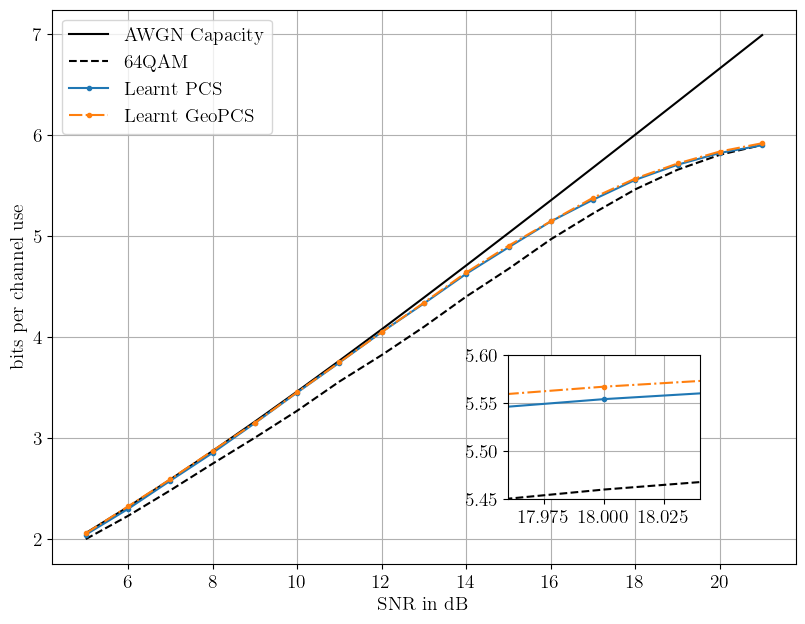

In [24]:
# Plot
plt.rcParams['figure.figsize'] = [8*1.2, 6*1.2]

fig, ax1 = plt.subplots()
ax1.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='AWGN Capacity')
ax1.plot(SNR_dBs, mi_64, color='black', ls='--', label = '64QAM')

ax1.plot(SNR_dBs, mi_pcs, color='C0', marker='o', markersize=3, label='Learnt PCS')
ax1.plot(SNR_dBs, mi_geo_pcs, color='C1', marker='o', markersize=3, ls='-.', label='Learnt GeoPCS')

ax1.legend(loc='upper left')
ax1.grid()
ax1.set_ylabel('bits per channel use')
ax1.set_xlabel('SNR in dB')


l, b, h, w = 0.6, .2, .2, .2
ax2 = fig.add_axes([l, b, w, h])

# plt.rcParams['figure.figsize'] = [4, 4]
ax2.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='AWGN Capacity')
ax2.plot(SNR_dBs, mi_64, color='black', ls='--', label = '64QAM')

ax2.plot(SNR_dBs, mi_pcs, color='C0', marker='o', markersize=3, label='Learnt PCS')
ax2.plot(SNR_dBs, mi_geo_pcs, color='C1', marker='o', markersize=3, ls='-.', label='Learnt GeoPCS')

# plt.legend()
ax2.grid()
ax2.set_ylim([5.45,5.6])
ax2.set_xlim([17.96,18.04])
# plt.ylabel('bits per channel use')
# plt.xlabel('SNR in dB')
# tikzplotlib.save("stark_gcs_18dB_exp_tikz.tex")
plt.show()
fig.savefig("embedded_aref.pdf", format="pdf", dpi=600)
